# Lab Deep Learning/ Recurrent Neural Networks/ in pytorch

## Using Many-to-One for movie rating predicton

**Author: created by geoffroy.peeters@telecom-paris.fr** with the help of Stéphane Lathuilière

For any remark or suggestion, please feel free to contact me.

## Objective:
You will implement two different networks to perform the automatic rating (0 or 1) of movies given the text of their reviews.
You will use the ```imdb``` (internet movie database) dataset.

The reviews are already available in the form of indexes that point to a word dictionary: each word is already encoded as an index in the dictionary.

## Import packages

In [27]:
from keras.datasets import imdb
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from argparse import Namespace

colab = True
student = True

## Parameters of the model

- We only consider the most used words in the word dictionary, we consider the top `param.n_word`
- We truncate/zero-pad each review to a length `param.T_x`

In [28]:
param = Namespace()

param.n_word = 5000 # --- input dimension
param.T_x = 100 # --- review length
param.index_word_from = 3 # --- indicate where the index start from (first index are used to indicate `PAD` `START` `UNK` tokens)

param.n_embedding = 32 # --- dimension of the embedding
param.n_lstm = 100 # --- dimension of the LSTM (for a<t> and c<t>)
param.n_out = 1 # --- binary classification problem

param.batch_size = 64
param.lr = 0.001
param.n_epoch = 8


## Import IMDB data

In [29]:
# --- Import the IMDB data and only consider the ``param.n_word``` most used words
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=param.n_word, index_from=param.index_word_from )

## Data content

- ```X_train``` and ```X_test``` are each a numpy array, shape=(25000,), of lists.
  - Each list represent a review; it is a sequence (represented as a list) of indexes (position of each word in the dictionary)

- ```y_train``` and ```y_test``` are each a numpy array, shape=(25000,) of intergers.
  - Each integer represent the values 0 (bad movie) or 1 (good movie)

type(X_train): <class 'numpy.ndarray'>
number of training sequences: X_train.shape: (25000,)
type(X_train[0]): <class 'list'>
length of the first training sequence: len(X_train[0]): 218
length of the second training sequence: len(X_train[1]): 189
list of data of the first training sequence: X_train[0]: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 2, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 

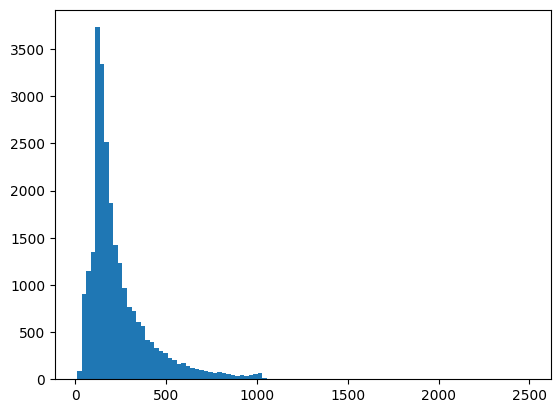

In [30]:
print("type(X_train):", type(X_train))
print("number of training sequences: X_train.shape:", X_train.shape)
print("type(X_train[0]):", type(X_train[0]))
print("length of the first training sequence: len(X_train[0]):",len(X_train[0]))
print("length of the second training sequence: len(X_train[1]):",len(X_train[1]))
print("list of data of the first training sequence: X_train[0]:", X_train[0] )
len_list = [len(train) for train in X_train]
print("maximum length of a training sequence:", max(len_list))

import matplotlib.pyplot as plt
plt.hist(len_list, 100);

## Details of how the reviews are encoded

In [31]:
word_to_id = imdb.get_word_index()
word_to_id = {key:(value+param.index_word_from) for key,value in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2

id_to_word = {value:key for key,value in word_to_id.items()}
print(' '.join(id_to_word[id] for id in X_train[1000] ))

<START> although i had seen <UNK> in a theater way back in <UNK> i couldn't remember anything of the plot except for vague images of kurt thomas running and fighting against a backdrop of stone walls and disappointment regarding the ending br br after reading some of the other reviews i picked up a copy of the newly released dvd to once again enter the world of <UNK> br br it turns out this is one of those films produced during the <UNK> that would go directly to video today the film stars <UNK> <UNK> kurt thomas as jonathan <UNK> <UNK> out of the blue to <UNK> the nation of <UNK> to enter and hopefully win the game a <UNK> <UNK> <UNK> by the khan who <UNK> his people by yelling what sounds like <UNK> power the goal of the mission involves the star wars defense system jonathan is trained in the martial arts by princess <UNK> who never speaks or leaves the house once trained tries to blend in with the <UNK> by wearing a bright red <UNK> with <UNK> of blue and white needless to say <UNK>

In [32]:
print("type(y_train):", type(y_train))
print("y_train.shape:", y_train.shape)
y_train[0]

type(y_train): <class 'numpy.ndarray'>
y_train.shape: (25000,)


1

In [33]:
print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)

X_test.shape: (25000,)
y_test.shape: (25000,)


## Data processing

Sequences (represented as a list of values) in `X_train` represent the reviews.
They can have different length $T_x$.
To train the network we should modify them so that they all have the same length `param.T_x`.

We do this by:
- **truncating** the ones that are too long,
- **padding-with-zeros** the ones that are too short.

This can be done at the start of the sequence (`pre`) or at the end (`post`).

In our use-case (rating of reviews), the decision ($\hat{y}$) is taken after reading the whole sentence/review ${x^{<t>}}$. Therefore we will truncate and pad-with-zeroes in `pre` mode (truncate the beginning of the sequence if too long, or add zeroes add the beggining of the sequence if too short).

In [34]:
def do_pad_sequences(sequences, required_len, truncating='pre', padding='pre'):
    """
    Parameters
    ----------
        sequences:  numpy arrays of lists, shape=(25000,)
        required_len:     required length of each sequence after truncating and padding
        padding     'pre' or 'post' mode
        truncating  'pre' or 'post' mode
    Returns
    -------
        padded_sequences    numpy arrays of lists (each list has now length maxlen)
    """
    if student:
        # --- START CODE HERE (01)
        
        padded_sequences = [np.zeros(required_len) for i in range(len(sequences))]
        for i, sequence in enumerate(sequences):
            if len(sequence) > required_len:
                if truncating == 'pre':
                    padded_sequences[i] = sequence[len(sequence)-required_len:]
                else:
                    padded_sequences[i] = sequence[:required_len]
            else:
                if padding == 'pre':
                    tmp = np.zeros(required_len)
                    tmp[required_len-len(sequence):] = sequence
                    padded_sequences[i] = tmp
                else:
                    tmp = np.zeros(required_len)
                    tmp[:len(sequence)] = sequence
                    padded_sequences[i] = tmp
        # --- END CODE HERE
    return padded_sequences


In [35]:
# --- truncate and pad input sequences
X_train = do_pad_sequences(X_train, required_len=param.T_x, padding='pre', truncating='pre')
X_test = do_pad_sequences(X_test, required_len=param.T_x, padding='pre', truncating='pre')

print("len(X_train[0]):", len(X_train[0]))
print("len(X_train[1]):", len(X_train[1]))
print("X_train[0]:", X_train[0])

len(X_train[0]): 100
len(X_train[1]): 100
X_train[0]: [1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 2, 19, 178, 32]


# Define training and testing functions

In [36]:
def train_one_epoch(model, data_loader, criterion, optimizer):
    """
    """

    model.train()
    total_loss, total_acc = 0, 0
    for X, y in data_loader:
        optimizer.zero_grad()
        hat_y = model(X)
        loss = criterion(hat_y.squeeze(), y)
        loss.backward() # --- SPECIFIC TO TRAINING
        optimizer.step() # --- SPECIFIC TO TRAINING

        total_loss += loss.item()
        predicted = (hat_y.squeeze() > 0.5).float()
        total_acc += (predicted == y).sum().item()/len(y)

    return total_loss/len(data_loader), total_acc/len(data_loader)



def test_one_epoch(model, data_loader, criterion):
    """
    """

    model.eval()
    total_loss, total_acc =  0, 0
    with torch.no_grad():
        for X, y in data_loader:
            hat_y = model(X)
            loss = criterion(hat_y.squeeze(), y)

            total_loss += loss.item()
            predicted = (hat_y.squeeze() > 0.5).float()
            total_acc += (predicted == y).sum().item()/len(y)

    return total_loss/len(data_loader), total_acc/len(data_loader)




def train(model, train_loader, test_loader, criterion, optimizer, n_epoch):
    """
    """

    for epoch in range(param.n_epoch):

        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
        print(f"Epoch {epoch + 1}, Loss: {train_loss }, Acc: {train_acc} ")

        test_loss, test_acc = test_one_epoch(model, test_loader, criterion)
        print(f"\tValidation Loss: {test_loss }, Acc: {test_acc} ")


In [37]:
# --- Convert numpy.array to torch.tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create TensorDatasets for train and test data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders for train and test data
train_loader = DataLoader(train_dataset, batch_size=param.batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=param.batch_size, shuffle=False)

# First model



In the first model, you will successively
- step-1) learn word embeddings $e^{<t>}$ of each item of the inut sequence $x^{(t)}$.
    - This is done by learning an embedding matrix $E$. You will use the `nn.Embedding` layer in pytorch.
    - In pytorch, the `nn.Embedding` layer does not really perform a matrix multiplication going from one-hot-encoding to embedding (it would be very costly to do that).
    - In pytorch `nn.Embedding` is a special layer that goes directly from index-of-the-word-in-the-dictionary to the embedding $e^{(t)}$
    - The embedding goes from `param.n_word` dimensions to  `param.n_embedding` dimensions
- step-2) compute the average over time $t$ of the embedding $e^{(t)}$ obtained for each word $x^{(t)}$ of a sequence (you should use `torch.mean`)
- step-3) apply a fully connected (`nn.linear` layer in pytorch) which output activation is a sigmoid (predicting the 0 or 1 rating)

<img src="https://perso.telecom-paristech.fr/gpeeters/doc/Lab_DL_RNN_01.png">



In [39]:
if student:
    # --- START CODE HERE (02)
    class SimpleModel(nn.Module):
        def __init__(self, param):
            super(SimpleModel, self).__init__()
            self.embedding = nn.Embedding(param.n_word, param.n_embedding)
            self.linear = nn.Linear(param.n_embedding, param.n_out)
            self.sigmoid = nn.Sigmoid()

        def forward(self, x):
            x = self.embedding(x)
            x = torch.mean(x, dim=1)
            x = self.linear(x)
            x = self.sigmoid(x)
            return x
            
    # --- END CODE HERE



# --- Test
torch.manual_seed(0)
model = SimpleModel(param)
print(X_train_tensor[:param.batch_size, :].size())
print(model(X_train_tensor[:param.batch_size, :]).size())

torch.Size([64, 100])
torch.Size([64, 1])


In [40]:
# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(),param.lr)

In [41]:
# Train the model
train(model, train_loader, test_loader, criterion, optimizer, param.n_epoch)

Epoch 1, Loss: 0.6747531944223683, Acc: 0.618486253196931 
	Validation Loss: 0.647277324858224, Acc: 0.6908967391304348 
Epoch 2, Loss: 0.5944449586789017, Acc: 0.7352062020460358 
	Validation Loss: 0.5432630098231918, Acc: 0.7694213554987213 
Epoch 3, Loss: 0.48974179345018726, Acc: 0.7975863171355498 
	Validation Loss: 0.45840003004159463, Acc: 0.8072250639386189 
Epoch 4, Loss: 0.41904126827979027, Acc: 0.8285805626598466 
	Validation Loss: 0.4102556744347448, Acc: 0.8243286445012787 
Epoch 5, Loss: 0.37674824539047985, Acc: 0.8445812020460358 
	Validation Loss: 0.38327096791371057, Acc: 0.8325207800511509 
Epoch 6, Loss: 0.34965070049323693, Acc: 0.8558583759590793 
	Validation Loss: 0.3671487530174158, Acc: 0.8377557544757033 
Epoch 7, Loss: 0.3303366062586265, Acc: 0.8615968670076726 
	Validation Loss: 0.3565715541467642, Acc: 0.842391304347826 
Epoch 8, Loss: 0.31547949404057946, Acc: 0.8678628516624042 
	Validation Loss: 0.3492689143742442, Acc: 0.8453884271099744 


## Results

After only 8 epochs, you should obtain an accuracy "around" 86.7%/ 84.5% for the test data.

## Using the trained embedding to find equivalence between words

Since the embedding is part of the models, we can look at the trained embedding matrix $E$ and use it to get the most similar words (according to the trained matrix $E$) in the dictionary.
You will use the weights of the `nn.Embedding` layer to find the most similar words to `great`. We will use an Euclidean distance for that.

- 1) Retrieve the weights of the `nn.Embedding` layer
- 2) Get the position of `great` in the dictionary
- 3) Knowing this position, get the word-embedding of `great`
- 4) Find (using Euclidean distance), the closest embedded-words to `great`

Remarks:
- you can access a specific layer of the model by using the name you used to define `self.??? = nn.Embedding` in the `__init__`method of `SimpleModel`.
- be careful about the order of the dimensions of the embedding matrix `E`

In [42]:
if student:
    # --- START CODE HERE (03)
    E = model.embedding.weight.data.numpy()
    great_id = word_to_id["great"]
    great_embedding = E[great_id]

    closest_words = []
    for i in range(E.shape[0]):
        if i != great_id:
            closest_words.append((i, np.linalg.norm(E[i]-great_embedding)))
    closest_words.sort(key=lambda x: x[1])

    closest_words = closest_words[:5]
    closest_words = [(id_to_word[i], dist) for i, dist in closest_words]
    print(closest_words)

    # --- END CODE HERE



[('fun', 6.3989644), ('masterpiece', 6.5136604), ('excellent', 6.737019), ('friendship', 6.99512), ('definite', 7.2948794)]


# Second model

In the second model, you will replace step-2 (which was "compute the average over time $t$ of the embedding $e^{(t)}$") by a RNN layer over time.
More precisely you will use a LSTM (`nn.LSTM` layer in pytorch) with `param.n_lstm=100` units (or dimensions) in a Many-To-One configuration

Don't forget that in ou data, the first dimension of `X_train/X_test` represents the batch (`batch_first=True` in pytorch).



In [44]:
if student:
    # --- START CODE HERE (04)
    class LstmModel(nn.Module):
        def __init__(self, param):
            super(LstmModel, self).__init__()
            self.embedding = nn.Embedding(param.n_word, param.n_embedding)
            self.lstm = nn.LSTM(param.n_embedding, param.n_lstm, batch_first=True)
            self.linear = nn.Linear(param.n_lstm, param.n_out)
            self.sigmoid = nn.Sigmoid()
        def forward(self, x):
            x = self.embedding(x)
            x, _ = self.lstm(x)
            x = torch.mean(x, dim=1)
            x = self.linear(x)
            x = self.sigmoid(x)
            return x
    # --- END CODE HERE


# --- Test
torch.manual_seed(0)
model = LstmModel(param)
print(X_train_tensor[:param.batch_size, :].size())
print(model(X_train_tensor[:param.batch_size, :]).size())

torch.Size([64, 100])
torch.Size([64, 1])


In [45]:
# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), param.lr)

In [47]:
# Train the model
train(model, train_loader, test_loader, criterion, optimizer, param.n_epoch)

Epoch 1, Loss: 0.2054774996531589, Acc: 0.9185501918158567 
	Validation Loss: 0.4106279779273226, Acc: 0.8368765984654731 
Epoch 2, Loss: 0.18143471522861734, Acc: 0.930954283887468 
	Validation Loss: 0.44083118682627176, Acc: 0.8359734654731459 
Epoch 3, Loss: 0.15634967361950813, Acc: 0.9417838874680308 
	Validation Loss: 0.4823674183443684, Acc: 0.8290920716112532 
Epoch 4, Loss: 0.13179815865462394, Acc: 0.9528132992327366 
	Validation Loss: 0.48385210232356624, Acc: 0.833935421994885 
Epoch 5, Loss: 0.10327770545259309, Acc: 0.9660805626598465 
	Validation Loss: 0.6196358690557577, Acc: 0.82889226342711 
Epoch 6, Loss: 0.08171159441075514, Acc: 0.9744245524296675 
	Validation Loss: 0.6751175280803304, Acc: 0.8225543478260869 
Epoch 7, Loss: 0.06410739379351402, Acc: 0.9793238491048593 
	Validation Loss: 0.7476454173664913, Acc: 0.8253196930946292 
Epoch 8, Loss: 0.04818912989714795, Acc: 0.9858136189258312 
	Validation Loss: 0.7861078207373924, Acc: 0.8226822250639386 


## Results

After only 8 epochs, you should obtain an accuracy around 91.1%/ 84.7% for the test data.

# Evaluation

To evaluate the work, you should rate the code for
- 1) Data Pre-Processing (01)
- 2) Simple model  (02)
- 3) Find equivalence between words (03)
- 4) LSTM model (04)
